### Demographics API

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
import pandas as pd
df = pd.read_csv("mturk_surveys.csv")
df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = map(lambda x : x.date(), df['hit_answered_date'])
df['time'] = map(lambda x : x.time(), df['hit_answered_date'])
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                 category
household_size                   category
location_city                      object
location_country                 category
location_region                    object
marital_status                   category
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
date                               object
time                               object
dtype: object

In [2]:
import datetime
minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])
days = (maxDate - minDate).days
print minDate
print maxDate
print days

2015-03-26 11:47:28.877000
2016-11-17 02:54:15.753000
601


In [3]:
df.head(5)

,gender,hit_answered_date,hit_creation_date,household_income,household_size,location_city,location_country,location_region,marital_status,post_to_completion_secs,worker_id,year_of_birth,date,time
0,male,2016-11-17 02:54:15.753,2016-11-17 02:53:10,"$10,000-$14,999",5+,indore,IN,mp,single,65.0,3c0ad9f0e4b106d727765215200a3c06,1997,2016-11-17,02:54:15.753000
1,female,2016-11-17 02:44:51.777,2016-11-17 02:38:09,"$15,000-$24,999",4,dallas,US,tx,married,402.0,f339c33e86e94c9f8ef879832139afdd,1990,2016-11-17,02:44:51.777000
2,female,2016-11-17 02:27:41.968,2016-11-17 02:23:11,"Less than $10,000",1,victoria,CA,bc,single,270.0,c4e92e4916889c6e4b82f4afd3fc5d63,1995,2016-11-17,02:27:41.968000
3,male,2016-11-17 02:20:53.469,2016-11-17 02:08:11,"$40,000-$59,999",2,amelia,US,oh,married,762.0,5981cb90e11c706868120513101ef47d,1956,2016-11-17,02:20:53.469000
4,male,2016-11-17 01:57:44.779,2016-11-17 01:53:11,"$25,000-$39,999",1,houston,US,tx,single,273.0,b0c2d1b05e811dd7694cc6cec59229c1,1986,2016-11-17,01:57:44.779000


### Exploratory plots

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
mpl.rc("figure", figsize=(16, 8))

### Capture Recapture model

We will now attempt to estimate the capture-recapture models in order to estimate the overall population size of MTurk workers.


We will start with the simplest models first, expanding to more complex approaches later:

The underlying assumptions:

1. Constant population over the two samples (i.e., no workers arrive or depart from the platform)
2. The workerID corresponds to a single worker (i.e., no sharing of accounts) and each worker has a single workerID.
3. All workers have the same propensity of participating in the survey.

#### Two-occasion Model (Lincoln Estimator)

This model assumes that we have two samples (the "capture" and the "recapture"). In our data set we have significiantly more data, which allows for more expressive and powerful models, but we will start with the simplest model first, to illustrate the approach.

In the first sample we "capture" (survey) $n_1$ workers out of the $N$ workers in the population. (We know $n_1$ but not $N$.) In the second sample we "recapture" $n_2$ workers out of the same population of $N$ workers, and we observe a set of $m$ workers both in the "capture" and "recapture" samples. Following a multinomial model with a maximum likelihood estimator, every time that we pick a worker in the second sample, the probability of the worker being the first sample is $n_1 / N$, so the total number of common workers in a sample of $n_2$ workers will be $m = \frac{n_1 \cdot n_2}{N}$. So, given that we know $m$, $n_1$ and $n_2$, we get our estimate for $N$ to be  $N = \frac{n_1 \cdot n_2}{m}$.

In [5]:
def getWorkerIDs(df, startDate, endDate):
    '''
    Returns the set of distinct workers that participated in the surveys between the two dates
    '''
    return set(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [6]:
def capture_recapture_lincoln_estimator(df, groupAstart, groupBstart, window):
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) / len(intersection)
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": (groupBstart - groupAstart).days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }


Let's try our estimate for the first and third months in the data set:

In [7]:
window = 30
offset = 0
date_diff = 60
first_date = minDate + datetime.timedelta(days=offset)
second_date = first_date + datetime.timedelta(days=date_diff)
capture_recapture_lincoln_estimator(df, first_date, second_date, window)

{'capture_recapture_estimate': 13410,
 'date_diff': 60,
 'groupA_end': Timestamp('2015-04-25 11:47:28.877000'),
 'groupA_start': Timestamp('2015-03-26 11:47:28.877000'),
 'groupB_end': Timestamp('2015-06-24 11:47:28.877000'),
 'groupB_start': Timestamp('2015-05-25 11:47:28.877000'),
 'window': 30,
 'workers_A': 2812,
 'workers_B': 2828,
 'workers_intersection': 593,
 'workers_union': 5047}

And try again for the 6th month and the 7th month in the data set

In [8]:
window = 30
offset = 180
date_diff = 30
first_date = minDate + datetime.timedelta(days=offset)
second_date = first_date + datetime.timedelta(days=date_diff)
capture_recapture_lincoln_estimator(df, first_date, second_date, window)

{'capture_recapture_estimate': 14747,
 'date_diff': 30,
 'groupA_end': Timestamp('2015-10-22 11:47:28.877000'),
 'groupA_start': Timestamp('2015-09-22 11:47:28.877000'),
 'groupB_end': Timestamp('2015-11-21 11:47:28.877000'),
 'groupB_start': Timestamp('2015-10-22 11:47:28.877000'),
 'window': 30,
 'workers_A': 2877,
 'workers_B': 2845,
 'workers_intersection': 555,
 'workers_union': 5167}

Now, we are going to try various pairs of dates (all for the same window of 30 days worth of sampling). 

In [9]:
import random

sample_size_dates = 200
sample_dates = random.sample(df['date'], sample_size_dates)

#sample_size_windows = 10
#sample_window = random.sample(range(days), sample_size_windows)
sample_window = [30]

result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate.date():
                    r = capture_recapture_lincoln_estimator(df,groupAstart, groupBstart, window)
                    result.append(r)



In [10]:
lincoln_estimates = pd.DataFrame(result)
lincoln_estimates.head(5)


,capture_recapture_estimate,date_diff,groupA_end,groupA_start,groupB_end,groupB_start,window,workers_A,workers_B,workers_intersection,workers_union
0,15842,266,2016-02-21,2016-01-22,2016-11-13,2016-10-14,30,2885,2894,527,5252
1,18152,216,2016-02-21,2016-01-22,2016-09-24,2016-08-25,30,2885,2888,459,5314
2,16040,154,2016-02-21,2016-01-22,2016-07-24,2016-06-24,30,2885,2880,518,5247
3,18248,194,2016-02-21,2016-01-22,2016-09-02,2016-08-03,30,2885,2878,455,5308
4,15785,146,2016-02-21,2016-01-22,2016-07-16,2016-06-16,30,2885,2878,526,5237


Now, let's see our estimated values:

In [11]:
import numpy as np

print np.mean(lincoln_estimates[['capture_recapture_estimate']])
print np.median(lincoln_estimates[['capture_recapture_estimate']])
print np.std(lincoln_estimates[['capture_recapture_estimate']])

capture_recapture_estimate    19506.661809
dtype: float64
18302.0
capture_recapture_estimate    5219.604976
dtype: float64


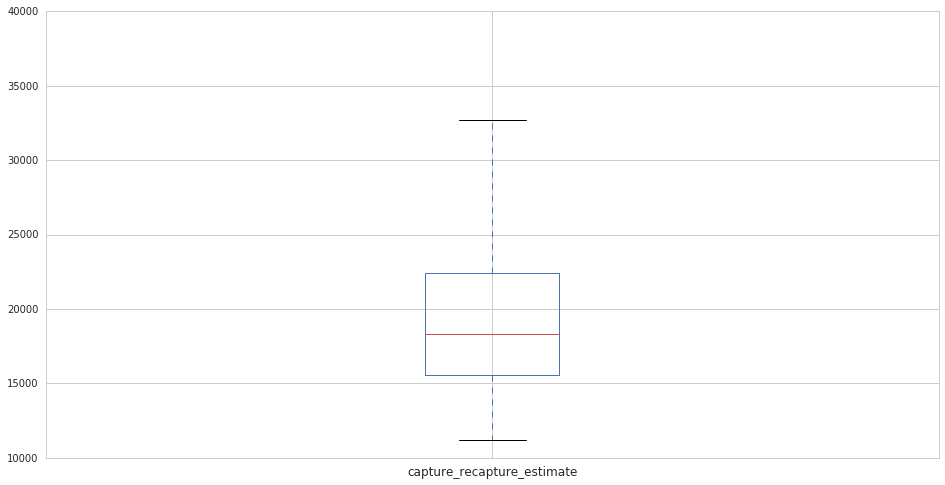

In [12]:
lincoln_estimates[['capture_recapture_estimate']].boxplot(figsize=(15,10), return_type='axes')

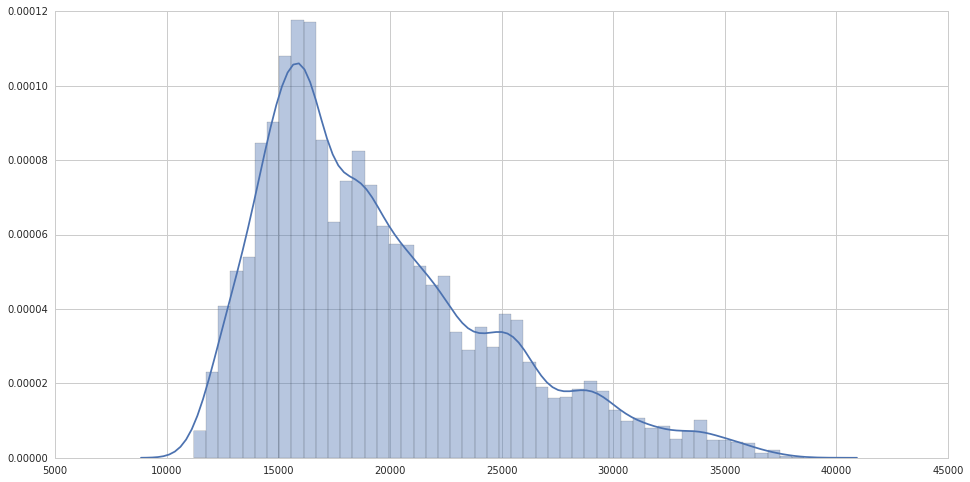

In [13]:
import seaborn as sns
sns.distplot(lincoln_estimates[['capture_recapture_estimate']]);

### The Schnabel estimator

We implement the Schnabel estimator following the guidelines at # http://www.esf.edu/efb/limburg/Fisheries/Assess_II_Pop/Pop_assessments_IIB.pdf

The Schnabel estimator uses multiple-census procedures:
you collect fish multiple times from your ecosystem, and
each time you collect, you note the number captured, the
number already marked (cumulatively), and you mark all
the new captures that weren’t already marked.

In [14]:
# Helper function
def getAllWorkerIDs(df, startDate, endDate):
    '''
    Returns all the ids of the workers that participated in the surveys between the two dates
    '''
    return list(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [15]:
# We will consider a period of "window" days as one catching period.
window = 30
dates = set(df['date'])

min_date = min(dates)
max_date = max(dates)

data = []
startDate = min_date
while startDate < max_date:
    endDate = startDate + datetime.timedelta(days=window)
    period_captured = getWorkerIDs(df, startDate, endDate)
    before_captured = getWorkerIDs(df, min_date, startDate)
    period_recaptured = len(period_captured & before_captured)
    period_unmarked = len(period_captured) - period_recaptured
    data.append( {"period_captured": len(period_captured), 
                  "period_recaptured": period_recaptured,
                  "period_unmarked": period_unmarked,
                  "before_captured": len(before_captured),
                  "startDate": startDate,
                 } 
               )
    startDate = endDate
    
schnabel = pd.DataFrame(data)
schnabel.set_index(keys='startDate', inplace=True)
schnabel.sort_index(inplace=True)


schnabel['total_recaptured'] = schnabel['period_recaptured'].cumsum()
schnabel['CxM'] = schnabel['before_captured'] * schnabel['period_captured']
schnabel['cum_CxM'] = schnabel['CxM'].cumsum()
schnabel['N_estimate'] = schnabel['cum_CxM'] / schnabel['total_recaptured']

schnabel

,before_captured,period_captured,period_recaptured,period_unmarked,total_recaptured,CxM,cum_CxM,N_estimate
startDate,,,,,,,,
2015-03-26,0,2768,0,2768,0,0,0,NaN
2015-04-25,2768,2875,522,2353,522,7958000,7958000,15245.210728
2015-05-25,5121,2830,804,2026,1326,14492430,22450430,16930.942685
2015-06-24,7147,2681,943,1738,2269,19161107,41611537,18339.152490
2015-07-24,8885,2860,1134,1726,3403,25411100,67022637,19695.162210
2015-08-23,10611,2881,1220,1661,4623,30570291,97592928,21110.302401
2015-09-22,12272,2871,1400,1471,6023,35232912,132825840,22053.103105
2015-10-22,13743,2844,1408,1436,7431,39085092,171910932,23134.293096
2015-11-21,15179,2890,1519,1371,8950,43867310,215778242,24109.300782


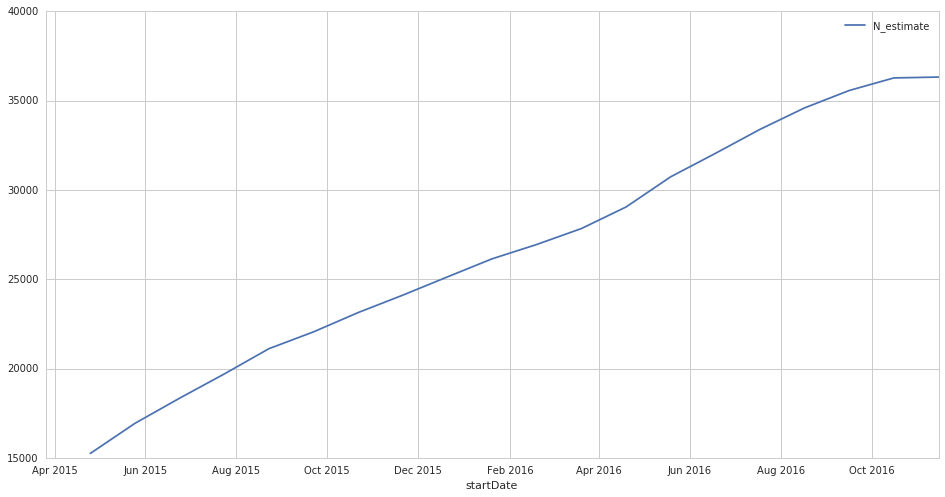

In [16]:
schnabel[['N_estimate']].plot()

We observe a strange trend. Our estimate of the worker population increases with the number of catching periods, instead of converging with the arrival of more data. 

This would be a direct violation of the underlying assumption of both models, which assume that the population is "closed". As we can see below, the same problem exists with the Lincoln estimator, as we can see below.

### Problems with the closed population assumption

In [17]:
# Just for bookkeeping convert the variables to correct data types
lincoln_estimates['groupA_start'] = pd.to_datetime(lincoln_estimates['groupA_start'])
lincoln_estimates['groupA_end'] = pd.to_datetime(lincoln_estimates['groupA_end'])
lincoln_estimates['groupB_start'] = pd.to_datetime(lincoln_estimates['groupB_start'])
lincoln_estimates['groupB_end'] = pd.to_datetime(lincoln_estimates['groupB_end'])

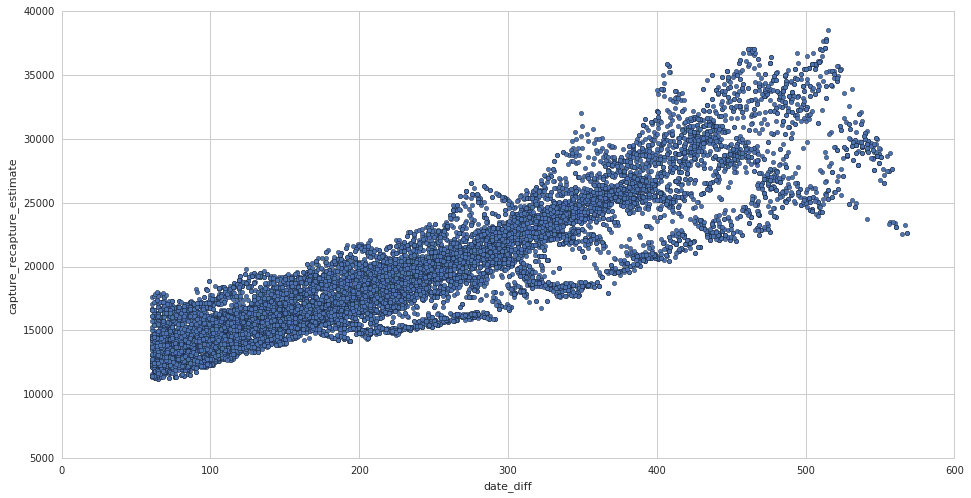

In [18]:
lincoln_estimates.plot.scatter(x='date_diff', y='capture_recapture_estimate')

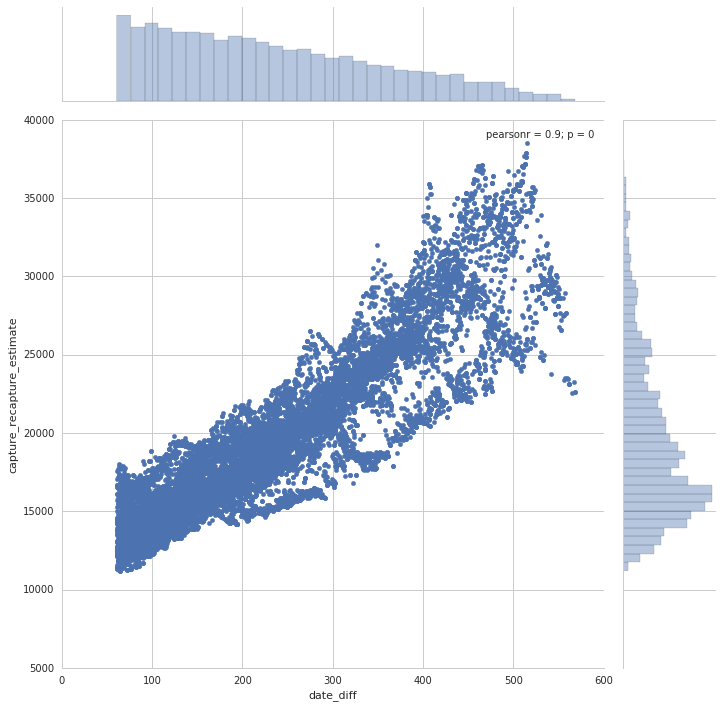

In [19]:
sns.jointplot(x='date_diff', y='capture_recapture_estimate', data=lincoln_estimates, size=10);

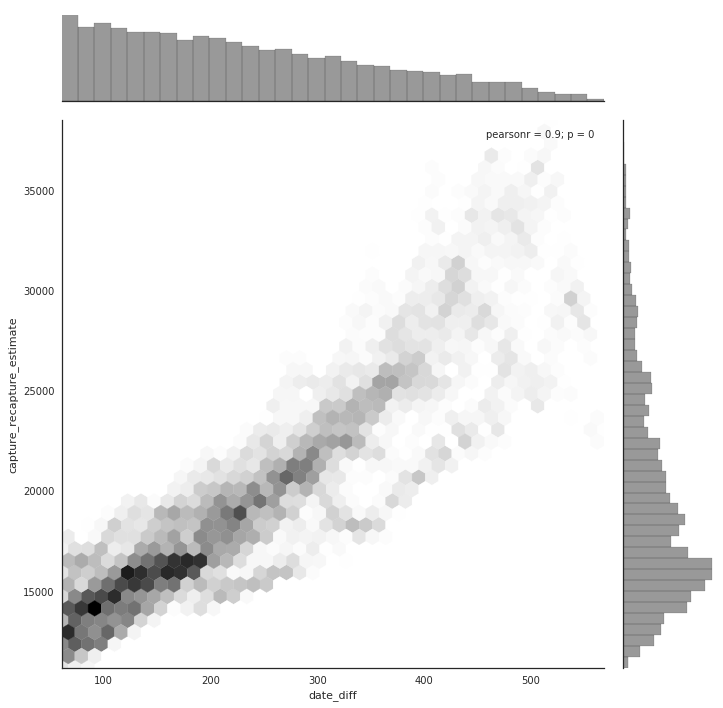

In [20]:
with sns.axes_style("white"):
    sns.jointplot(x='date_diff', y='capture_recapture_estimate', data=lincoln_estimates, kind="hex", color = 'k', size=10);

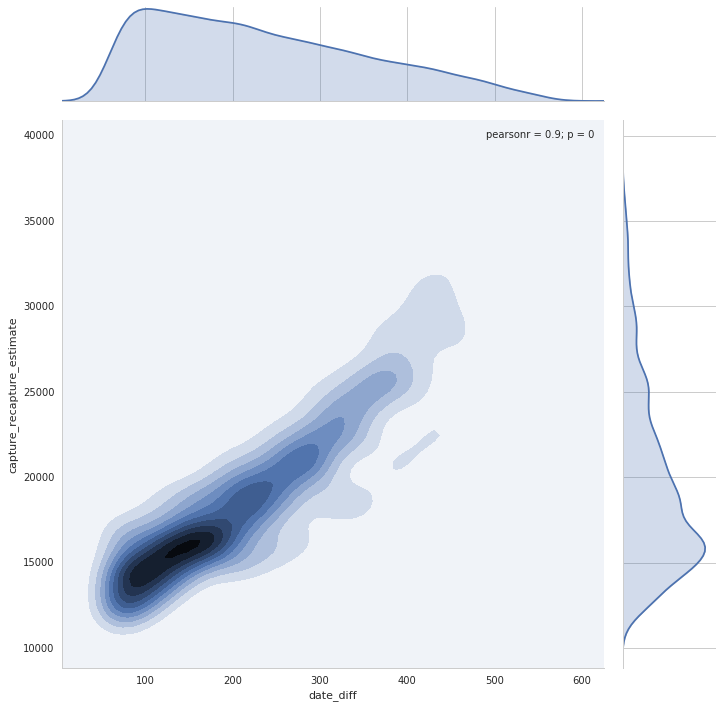

In [21]:
sns.jointplot(x='date_diff', y='capture_recapture_estimate', data=lincoln_estimates, kind="kde", size=10);

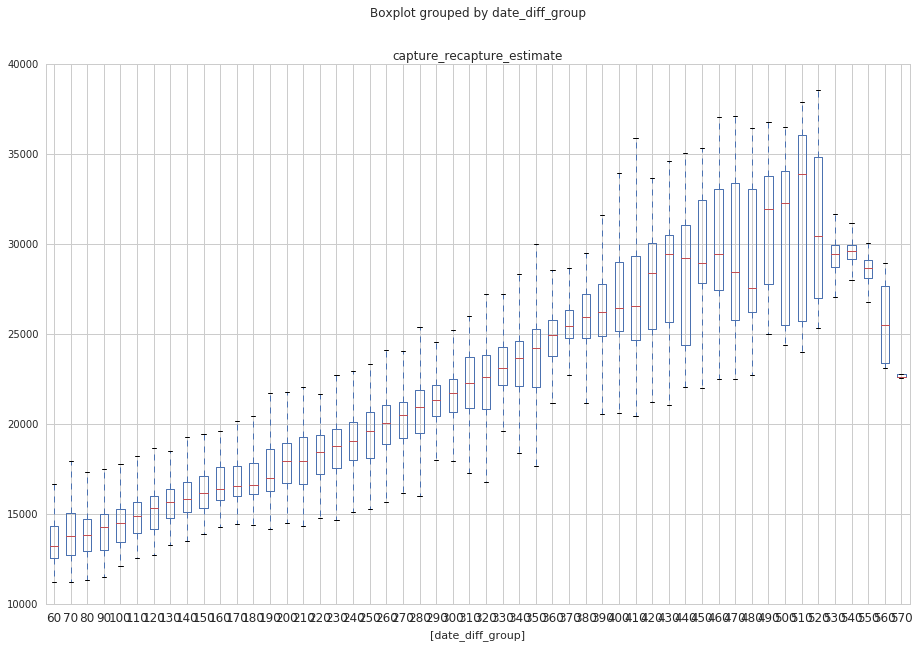

In [22]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 10 days
lincoln_estimates['date_diff_group'] = map(lambda x : int(round(x , -1)), lincoln_estimates['date_diff'])
lincoln_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

Our results indicate that the population estimates are increasing as the difference in dates between datasets increases. This is not normal behavior under the ``closed world'' assumption of the Lincoln estimator, indicating that the assumptions of the model are violated. As we will see below, the key problem is the fact that new workers arrive (are "born"), and old workers quit ("die"). Furhtermore, as we have seen earlier, we see that Amazon opened the registration for non-US workers, allowing "immigration" into our area.

### Allowing for arrival and departure of workers from the population

In [23]:
# We will consider a period of "window" days as one catching period.
window = 14
dates = set(df['date'])

min_date = min(dates)
max_date = max(dates)

data = {}
worker_ids = {}
startDate = min_date
period = 0
while startDate < max_date:
    endDate = startDate + datetime.timedelta(days=window)
    period_captured_ids = getWorkerIDs(df, startDate, endDate)
    worker_ids[period] = period_captured_ids
    
    before_captured_ids = getWorkerIDs(df, min_date, startDate)
    after_captured_ids = getWorkerIDs(df, endDate, max_date)
    before_captured = len(before_captured_ids)
    period_marked = len(period_captured_ids & before_captured_ids)
    period_unmarked = len(period_captured_ids) - period_marked
    period_total = len(period_captured_ids)
    
    period_ids_captured_later = len(period_captured_ids & after_captured_ids)
    before_captured_ids_captured_later = len(before_captured_ids & after_captured_ids)
    
    period_survival = 1.0*period_ids_captured_later / period_total
    if before_captured>0:
        before_survival = 1.0*before_captured_ids_captured_later / before_captured
    else:
        before_survival = -1

    if before_survival>0:
        ratio = period_survival / before_survival
    else:
        ratio = -1

 
    data[period] = {"period_id": period,
                  "before_captured": before_captured,
                  "period_captured": period_total, 
                  "period_marked": period_marked,
                  "period_unmarked": period_unmarked,
                  "startDate": startDate,
                    "endDate": endDate
                 } 

    startDate = endDate
    period += 1

jollyseber = pd.DataFrame(data)
jollyseber.T

,before_captured,endDate,period_captured,period_id,period_marked,period_unmarked,startDate
0,0,2015-04-09,1255,0,0,1255,2015-03-26
1,1255,2015-04-23,1326,1,0,1326,2015-04-09
2,2581,2015-05-07,1336,2,159,1177,2015-04-23
3,3758,2015-05-21,1343,3,288,1055,2015-05-07
4,4813,2015-06-04,1297,4,313,984,2015-05-21
5,5797,2015-06-18,1344,5,416,928,2015-06-04
6,6725,2015-07-02,1338,6,386,952,2015-06-18
7,7677,2015-07-16,1151,7,423,728,2015-07-02
8,8405,2015-07-30,1337,8,503,834,2015-07-16
9,9239,2015-08-13,1338,9,532,806,2015-07-30


In [24]:
survival_probs = []
for period_from in worker_ids.keys():
    period_from_ids = worker_ids.get(period_from)
    for period_to in worker_ids.keys():
        date_diff = (data[period_to]['startDate'] - data[period_from]['startDate']).days
        if date_diff<=0:
            continue
        buffr = (data[period_to]['startDate'] - data[period_from]['endDate']).days
        if buffr < 30:
            continue
        period_to_ids = worker_ids.get(period_to)
        intersection = period_from_ids & period_to_ids
        survival_likelihood = 1.0*len(intersection) / len(period_from_ids)
        survival_probs.append( { "diff":date_diff, "survival": survival_likelihood} )
        
survival_df = pd.DataFrame(survival_probs)


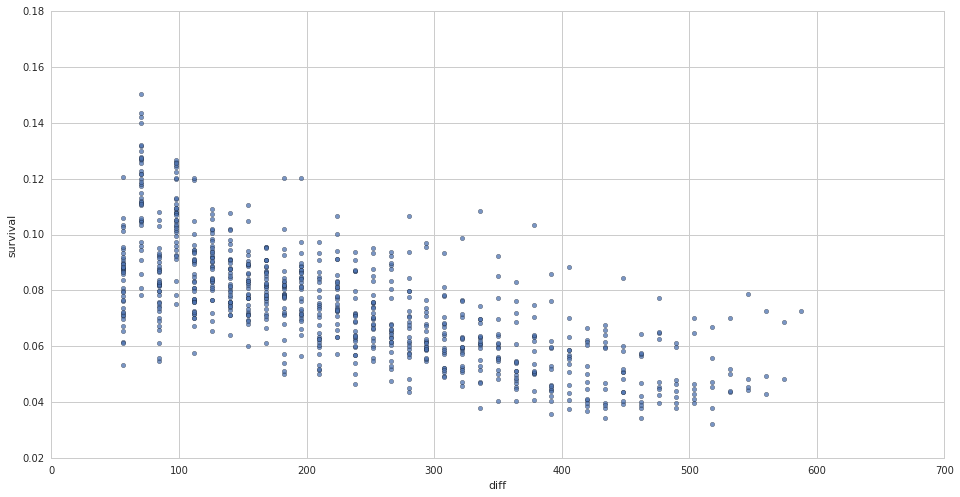

In [25]:
survival_df.plot.scatter(x='diff', y='survival', alpha=0.75)

In [26]:
#survival_df['diff'] = map(lambda x : int(round(x , -1)), survival_df['diff'])
#survival_df = survival_df[survival_df['diff']>30]
#survival_table = survival_df.groupby(by='diff').median()
#surv_diffs = -survival_table.diff().shift(-1)
#1 - surv_diffs / survival_table


In [27]:
# np.median((1 - surv_diffs / survival_table)[:-1])

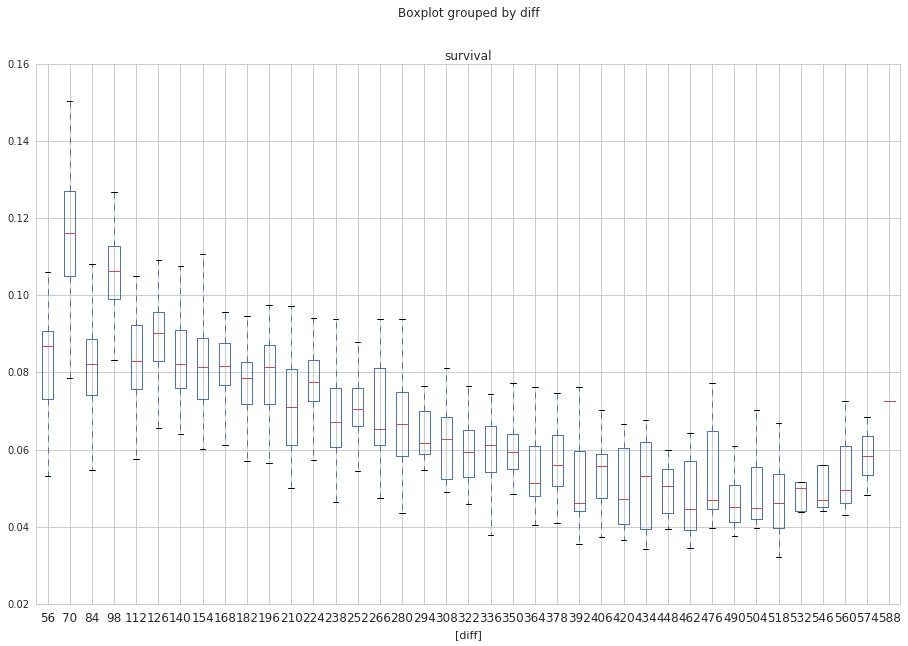

In [28]:
survival_df[['diff','survival']].boxplot(by='diff', figsize=(15,10))

Hence, we can model our current survival function as 

$S(t) = K \cdot \exp(-\lambda \cdot t)$

wotj $K$ being the expected intersection value when we run contemporaneous surveys, and $\lambda$ being the decay rate.



In [29]:
# Assuming an exponential survival function S(t) = K * exp(-lambda * t)
import math
import statsmodels.formula.api as sm
survival_df['logsurvival'] = map(lambda x : math.log(x), survival_df['survival'])
result = sm.ols(formula="logsurvival ~ diff", data=survival_df).fit()
print result.params

Intercept   -2.260124
diff        -0.001589
dtype: float64


In [30]:
fit_K = math.exp(result.params['Intercept'])
fit_l = -result.params['diff']

print "K =", fit_K
print "labda =", fit_l
print "Half-life =", math.log(2)/fit_l

K = 0.104337523865
labda = 0.00158879908816
Half-life = 436.271134422


In [31]:
def survival(t, l = fit_l):
    return 1
    #return np.exp(-fit_l*t)

In [32]:
sample_dates = set(df['date'])
len(sample_dates)

603

In [33]:
def capture_recapture_with_survival(df, groupAstart, groupBstart, window):
    
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    diff_days = (groupBstart - groupAstart).days
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) * survival(diff_days)  / len(intersection)
    else:
        capture_recapture_estimate = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": diff_days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate
    }


import random

#sample_size_dates = 200
#sample_dates = random.sample(df['date'], sample_size_dates)
sample_dates = set(df['date'])

#sample_size_windows = 10
#sample_window = random.sample(range(days), sample_size_windows)
sample_window = [30]

result = []
for groupAstart in sample_dates:
    for groupBstart in sample_dates:
        for window in sample_window:
            if groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and groupBstart + datetime.timedelta(days=window) < maxDate.date():
                    if groupBstart - groupAstart >= datetime.timedelta(days=60) and groupBstart - groupAstart <= datetime.timedelta(days=120):
                        r = capture_recapture_with_survival(df,groupAstart, groupBstart, window)
                        result.append(r)



In [34]:
crs_estimates = pd.DataFrame(result)
crs_estimates.head(5)

,capture_recapture_estimate,date_diff,groupA_end,groupA_start,groupB_end,groupB_start,window,workers_A,workers_B,workers_intersection,workers_union
0,14172,75,2015-08-25,2015-07-26,2015-11-08,2015-10-09,30,2866,2878,582,5162
1,15571,112,2015-08-25,2015-07-26,2015-12-15,2015-11-15,30,2866,2885,531,5220
2,13438,68,2015-08-25,2015-07-26,2015-11-01,2015-10-02,30,2866,2879,614,5131
3,14156,103,2015-08-25,2015-07-26,2015-12-06,2015-11-06,30,2866,2850,577,5139
4,13458,64,2015-08-25,2015-07-26,2015-10-28,2015-09-28,30,2866,2874,612,5128


In [35]:
len(crs_estimates)

28890

In [36]:
print np.mean(crs_estimates[['capture_recapture_estimate']])
print np.median(crs_estimates[['capture_recapture_estimate']])
print np.std(crs_estimates[['capture_recapture_estimate']])

capture_recapture_estimate    14372.415853
dtype: float64
14269.0
capture_recapture_estimate    1502.831861
dtype: float64


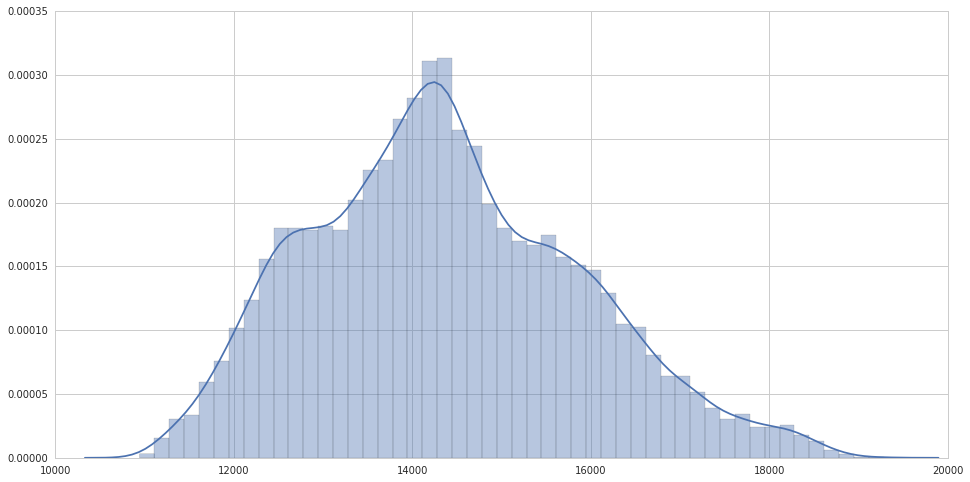

In [37]:
import seaborn as sns
sns.distplot(crs_estimates[['capture_recapture_estimate']]);

In [38]:
# Just for bookkeeping convert the variables to correct data types
crs_estimates['groupA_start'] = pd.to_datetime(crs_estimates['groupA_start'])
crs_estimates['groupA_end'] = pd.to_datetime(crs_estimates['groupA_end'])
crs_estimates['groupB_start'] = pd.to_datetime(crs_estimates['groupB_start'])
crs_estimates['groupB_end'] = pd.to_datetime(crs_estimates['groupB_end'])

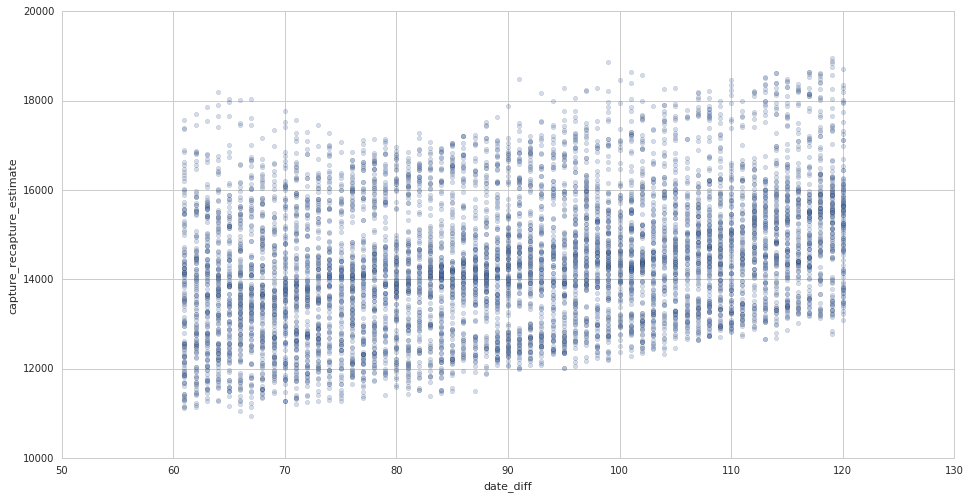

In [39]:
crs_estimates.sample(frac=0.25).plot.scatter(x='date_diff', y='capture_recapture_estimate', alpha=0.25)

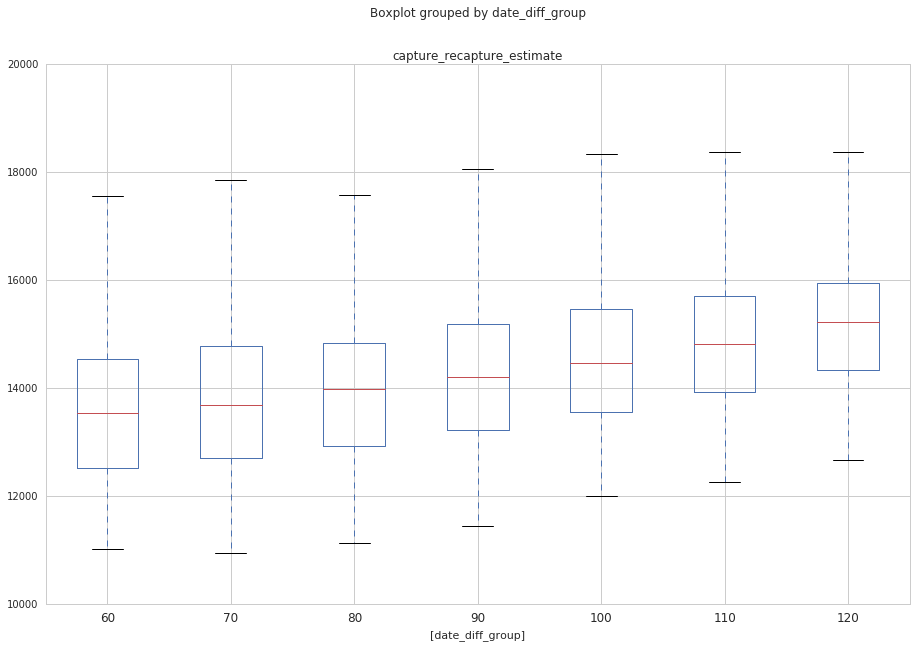

In [40]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 10 days
crs_estimates['date_diff_group'] = map(lambda x : int(round(x , -1)), crs_estimates['date_diff'])
crs_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

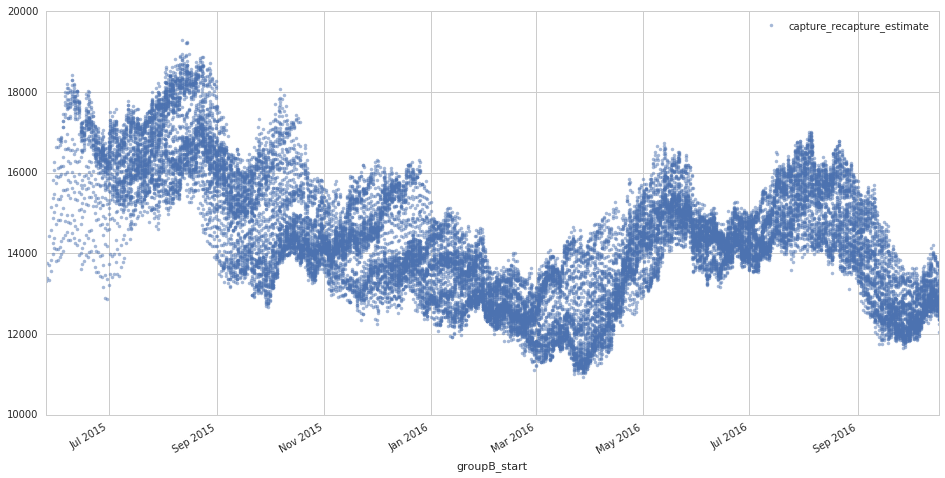

In [41]:
crs_estimates.plot(x='groupB_start', y='capture_recapture_estimate', alpha=0.5, style=".")

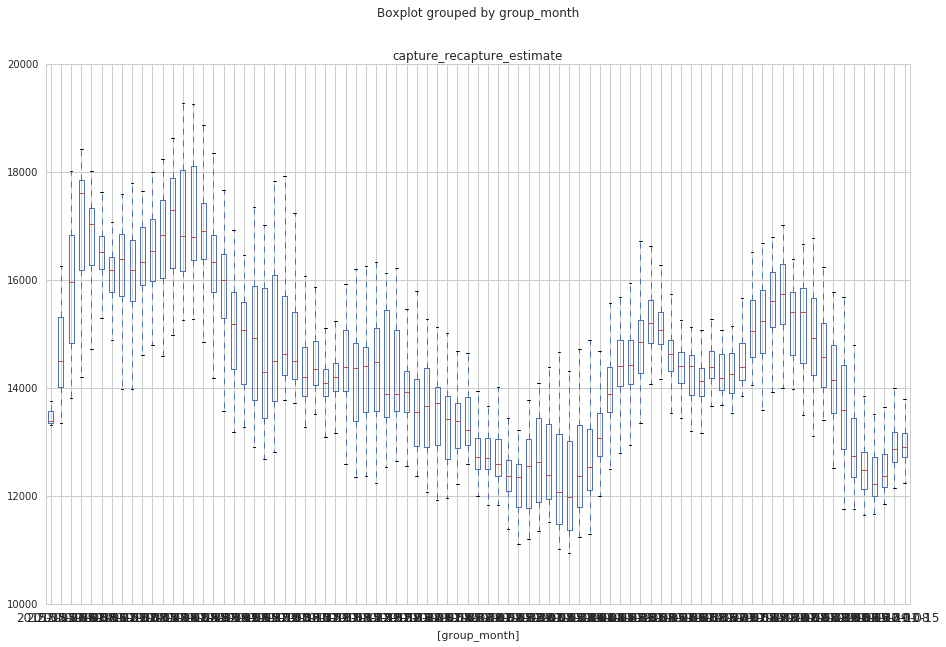

In [42]:
crs_estimates['group_month'] = map(lambda dt : dt.replace(hour=0, minute=0, second=0, microsecond=0, day=7*(dt.day/7)+1).date(), crs_estimates['groupB_start'])
crs_estimates[['group_month','capture_recapture_estimate']].boxplot(by='group_month', figsize=(15,10))

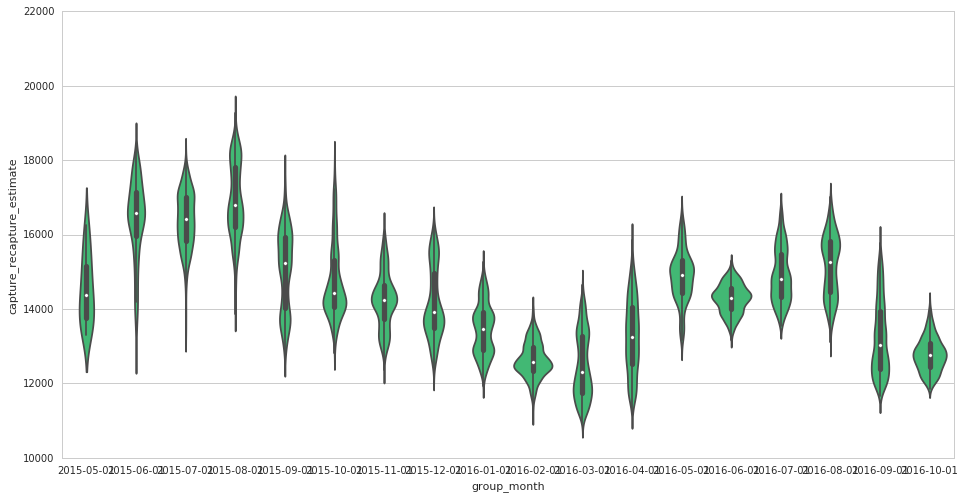

In [43]:
crs_estimates['group_month'] = map(lambda dt : dt.replace(hour=0, minute=0, second=0, microsecond=0, day=1).date(), crs_estimates['groupB_start'])
sns.violinplot(x='group_month', y='capture_recapture_estimate', data=crs_estimates.sort_values(by='group_month'), color="#2ecc71")

### Multiple Recapture Models

Our estimation process at this point relied on performing multiple two-sided comparisons and using the Linconln estimator.
Alternatively, we can use the Multiple Recapture Models introduced by Schnabel (1938) and Darroch (1958).





In [ ]:
# How often do we see each worker?
df['worker_id'].value_counts()

In [ ]:
# Let's compute the frequency of captures
df['worker_id'].value_counts().value_counts()

In [ ]:
df['worker_id'].value_counts().value_counts().sort_index().plot.bar(logy=True)

In [ ]:
df['worker_id'].value_counts().value_counts(normalize=True).sort_index()

In [ ]:
df['worker_id'].value_counts().value_counts(normalize=True).sort_index().plot.bar(logy=True)